Template to train the Autoencoder / Encoder

In [2]:
import sys
import yaml
import phate
import torch
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger

sys.path.append("../")
from src.models.lit_encoder import LitAutoencoder
from src.data.make_dataset import train_dataloader

/home/mila/g/guillaume.huguet/.conda/envs/phate_fim/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [22]:
# Data Parameters
dataset = "tree"
n_obs = 5000
n_dim = 10
batch_size = 100

# Model param
input_dim = n_dim
encoder_layer = [10, 10, 10, 2]
emb_dim = encoder_layer[-1]
activation = "ReLU"
lr = 0.001
kernel_type = "phate"  # "gaussian" and "phate".
loss_emb = True  # Embedding loss.
loss_dist = True # distance loss in the embedding.
bandwitdh = 1  # bandwitdh for the gaussian kernel
t = 1  # time for the gaussian kernel. For PHATE, we use their optimal time.
scale = 0.005  # scale when we add noise to do the data (before the encoder).

# Trainer param
max_epochs = 20
fast_dev_run = False
accelerator = "gpu"
devices = 1

exp_name = "phate_emb"
seed = torch.randint(0, 1000, size=(1,))

In [23]:
# Uncomment to save the params.

# params = {"dataset":dataset, "n_obs":n_obs, "n_dim":n_dim, "batch_size":batch_size, "input_dim":input_dim, "encoder_layer":encoder_layer, "activation":activation, "lr":lr,
#            "kernel_type":kernel_type, "loss_emb":loss_emb, "max_epochs":max_epochs, "fast_dev_run":fast_dev_run, "accelerator":accelerator, "devices":devices, "exp_name":exp_name, "seed":seed, "bandwitdh":bandwitdh, "t":t, "scale":scale}

# with open("runs/param_"+exp_name+".yaml","w") as file:
#     yaml.dump(params,file)

In [24]:
# If you want to save and view in Wandb
wandb = False
logger = WandbLogger(project="fim_phate", name=exp_name) if wandb else False

In [25]:
# SEED
pl.utilities.seed.seed_everything(seed=seed)

# data loader for the training set.
train_loader = train_dataloader(dataset, n_obs, n_dim, emb_dim, batch_size)

# Defining the pytorch lightning model.
model = LitAutoencoder(
    input_dim=input_dim,
    encoder_layer=encoder_layer,
    activation=activation,
    lr=lr,
    kernel_type=kernel_type,
    loss_emb=loss_emb,
    loss_dist=loss_dist,
    bandwitdh=bandwitdh,
    t=t,
    scale=scale,
)

# Defining the trainer
# NOTE, we can add more things like gradient clipping, early stopping, Callbacks etc..
# NOTE logger is set to `FALSE`, change to `True` to keep tracks of the metrics.
# NOTE  `enable_checkpointing ` is set to `False`, set to `True` to keep checkpoints of the model.
trainer = Trainer(
    max_epochs=max_epochs,
    fast_dev_run=fast_dev_run,
    accelerator=accelerator,
    devices=devices,
    logger=logger,
    enable_checkpointing=False,
)

# Train the model
trainer.fit(model, train_dataloaders=train_loader)

Global seed set to 872
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 352   
---------------------------------------
352       Trainable params
0         Non-trainable params
352       Total params
0.001     Total estimated model params size (MB)
/home/mila/g/guillaume.huguet/.conda/envs/phate_fim/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:219: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 19: 100%|██████████| 50/50 [00:01<00:00, 42.18it/s, loss=16.9]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 50/50 [00:01<00:00, 42.10it/s, loss=16.9]


In [26]:
from src.data.make_dataset import make_n_sphere, make_tree

X, Y = make_tree(dim=n_dim)

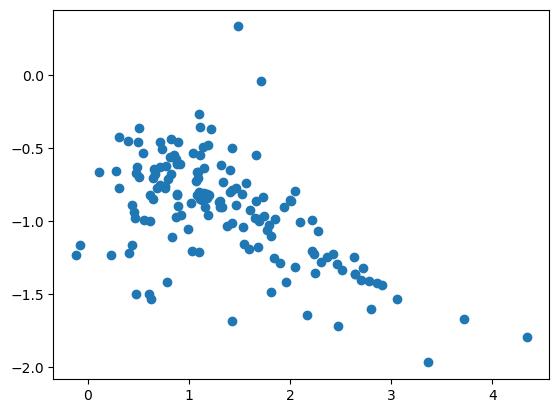

In [27]:
pred = model.forward(X)
import matplotlib.pyplot as plt

pred = pred.detach().cpu().numpy()
plt.scatter(pred[:, 0], pred[:, 1])

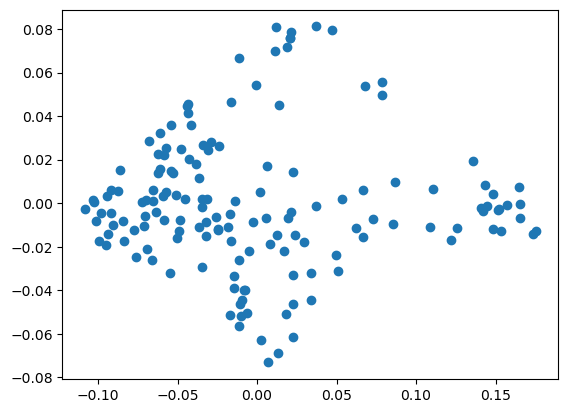

In [28]:
phate_operator = phate.PHATE(random_state=42, verbose=False, n_components=emb_dim)
phate_sphere = phate_operator.fit_transform(X.cpu().detach())
plt.scatter(phate_sphere[:, 0], phate_sphere[:, 1])